In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

In [2]:
def show_images(imgs, num_imgs = 25, nrow = 5, show = True):
    imgs_ = (imgs.detach().cpu() + 1) / 2
    img_grid = make_grid(imgs_[:num_imgs], nrow = nrow).permute([1, 2, 0]).squeeze()
    plt.imshow(img_grid)
    plt.axis("off")
    if show:
        plt.show()

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

dataset = MNIST(root = ".",
                train = True,
                transform = transform,
                download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5091983.13it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133816.70it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1276088.90it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6446879.45it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

In [5]:
dataloader = DataLoader(dataset = dataset,
                        batch_size = batch_size,
                        shuffle = True)

In [6]:
for sample_imgs, _ in dataloader:
    break

sample_imgs = sample_imgs.to(device)

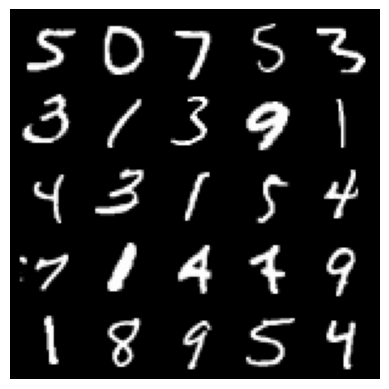

In [7]:
show_images(sample_imgs)

In [8]:
class Generator(nn.Module):
    def __init__(self, noise_dim, im_channels, hidden_dim):
        super().__init__()
        self.gen = nn.Sequential(
            self.get_gen_block(noise_dim, hidden_dim * 4, 3, 2),
            self.get_gen_block(hidden_dim * 4, hidden_dim * 2, 4, 1),
            self.get_gen_block(hidden_dim * 2, hidden_dim, 3, 2),
            self.get_gen_block(hidden_dim, 1, 4, 2, last_layer = True),
        )

    def get_gen_block(self, in_ch, out_ch, ker_sz, stride, last_layer = False):
        if not last_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, ker_sz, stride),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)
            )
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, ker_sz, stride),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.gen(noise.view(len(noise), -1, 1, 1))

In [9]:
def get_noise(num_samples, noise_dim, device = device):
    return torch.randn([num_samples, noise_dim], device = device)

In [10]:
sample_noise = get_noise(batch_size, noise_dim = 64, device = device)
sample_gen = Generator(noise_dim = 64, im_channels = 1, hidden_dim = 64).to(device)

sample_gen(sample_noise).shape

torch.Size([128, 1, 28, 28])

In [11]:
class Critic(nn.Module):
    def __init__(self, im_ch, hidden_dim):
        super().__init__()
        self.crit = nn.Sequential(
            self.get_crit_block(im_ch, hidden_dim, 4, 2),
            self.get_crit_block(hidden_dim, hidden_dim * 2, 4, 2),
            self.get_crit_block(hidden_dim * 2, 1, 4, 2, last_layer = True)
        )

    def get_crit_block(self, in_ch, out_ch, ker_sz, stride, last_layer = False):
        if not last_layer:
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, ker_sz, stride),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace = True)
            )
        return nn.Conv2d(in_ch, out_ch, ker_sz, stride)

    def forward(self, imgs):
        return self.crit(imgs).view(-1, 1)

In [12]:
sample_critic = Critic(im_ch = 1, hidden_dim = 64).to(device)

for imgs, _ in dataloader:
    break

imgs = imgs.to(device)
sample_critic(imgs).shape

torch.Size([128, 1])

In [29]:
num_epochs = 30
hidden_dim = 64
noise_dim = 64
display_step = 500
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5

In [30]:
gen = Generator(noise_dim = noise_dim, im_channels = 1, hidden_dim = 64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))
crit = Critic(im_ch = 1, hidden_dim = 64).to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr = lr, betas = (beta_1, beta_2))

In [31]:
def get_gradient(crit, real, fake, eps):
    img = real*eps + fake*(1-eps)
    img_out = crit(img)
    return torch.autograd.grad(
        outputs = img_out,
        inputs = img,
        grad_outputs = torch.ones_like(img_out),
        create_graph = True,
        retain_graph = True
    )[0]

In [32]:
def gradient_penalty(grad):
    grad_ = grad.view(-1, 1)
    grad_norm = grad_.norm(2, dim = 1)
    return ((grad_norm - 1) * (grad_norm - 1)).sum() / len(grad_)

In [33]:
def get_gen_loss(crit, fake):
    return -crit(fake).mean()

In [34]:
def get_crit_loss(crit, real, fake, gp, c_lambda):
    return crit(fake).mean()  - crit(real).mean() + (c_lambda * gp)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 1, step : 500, gen_loss : 21.395165600687264, crit_loss : -101.85224296474455


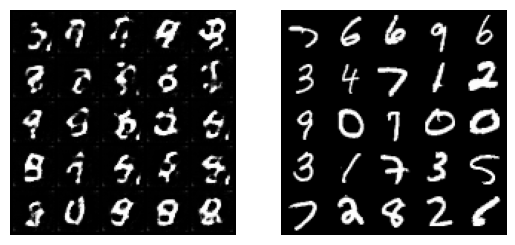

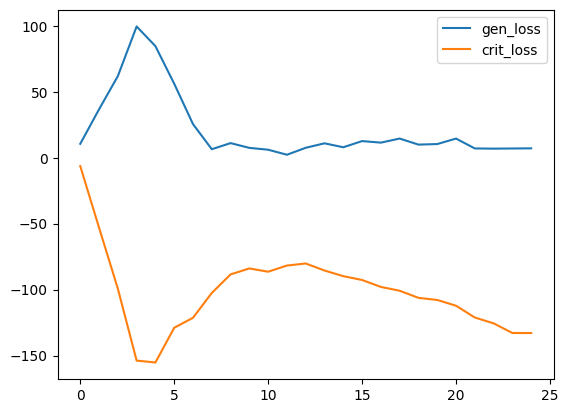



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 2, step : 1000, gen_loss : 28.514250195145607, crit_loss : -185.66329061279296


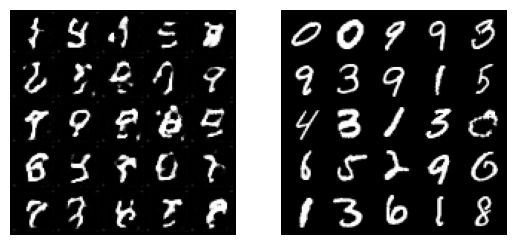

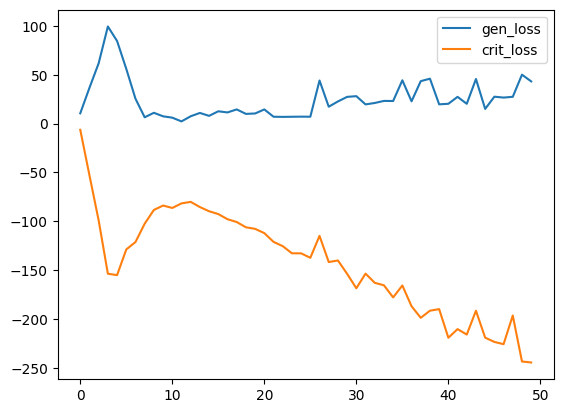



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 3, step : 1500, gen_loss : 70.39593552875519, crit_loss : -244.89106603775028


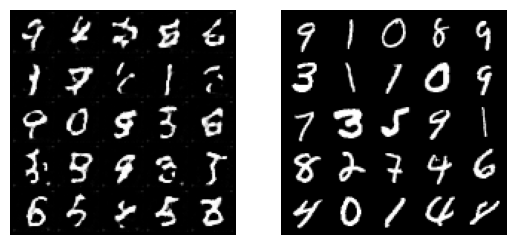

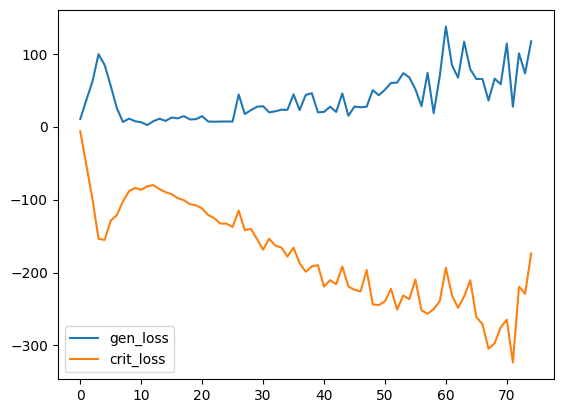



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 4, step : 2000, gen_loss : 72.10362738204002, crit_loss : -291.837718362427


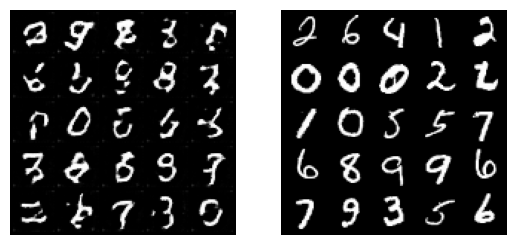

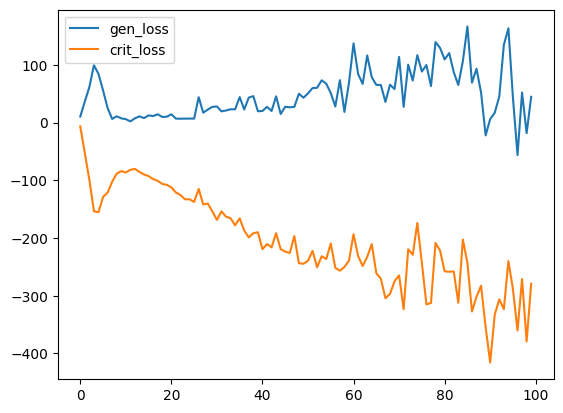



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 5, step : 2500, gen_loss : 141.92059377479552, crit_loss : -279.44942831268287


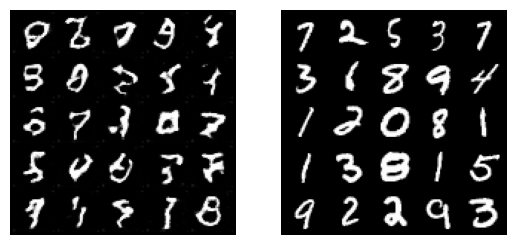

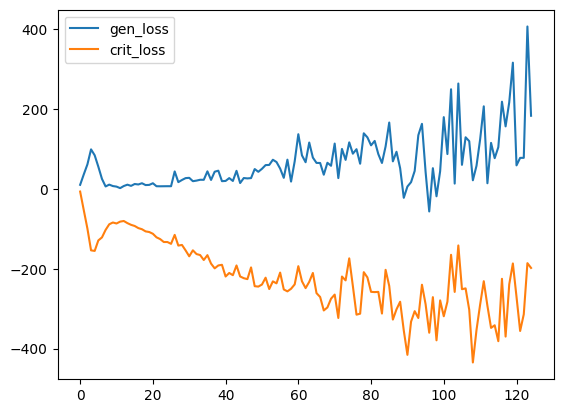



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 6, step : 3000, gen_loss : 157.2776723356247, crit_loss : -303.49196239395144


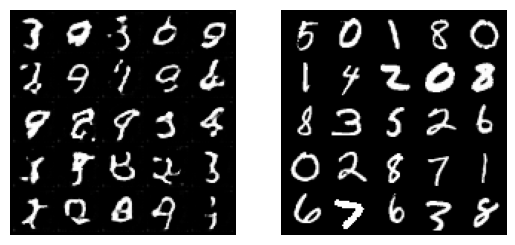

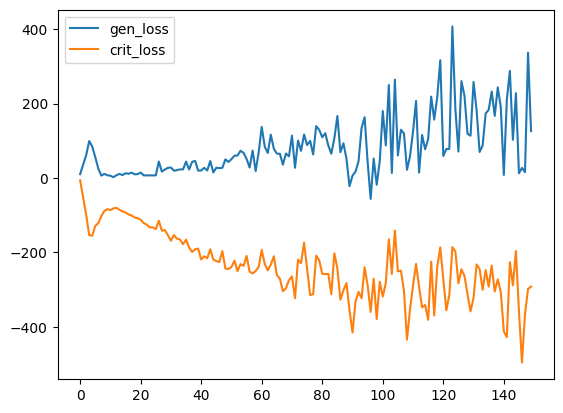



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 7, step : 3500, gen_loss : 169.7830445804596, crit_loss : -320.519702160645


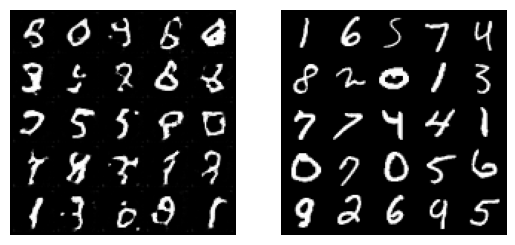

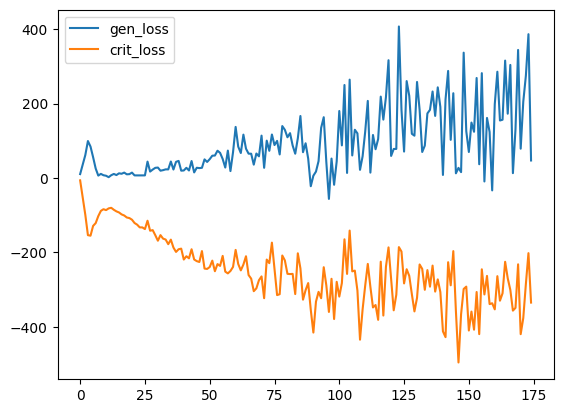



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 8, step : 4000, gen_loss : 179.12869058418275, crit_loss : -329.28323892059325


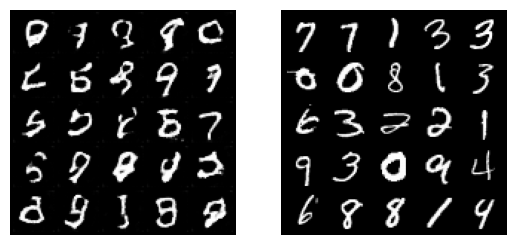

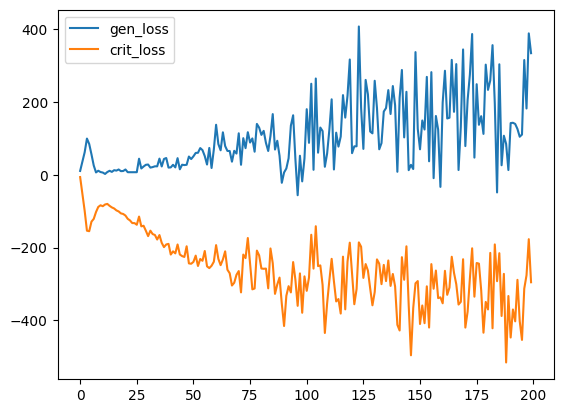



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 9, step : 4500, gen_loss : 247.29530727863312, crit_loss : -282.2809147521971


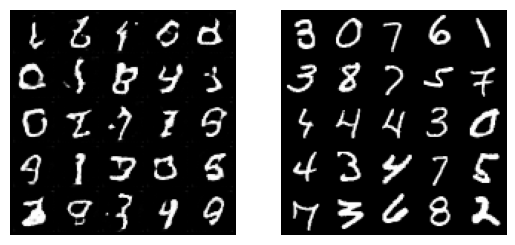

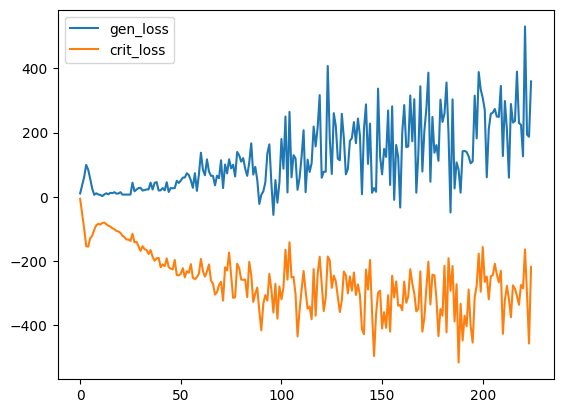



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 10, step : 5000, gen_loss : 315.97462384724616, crit_loss : -292.7790540847779


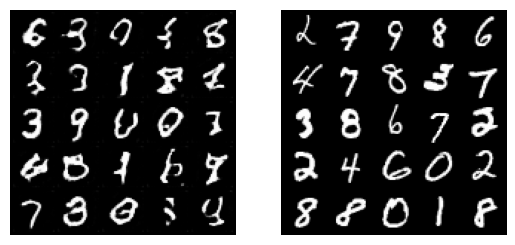

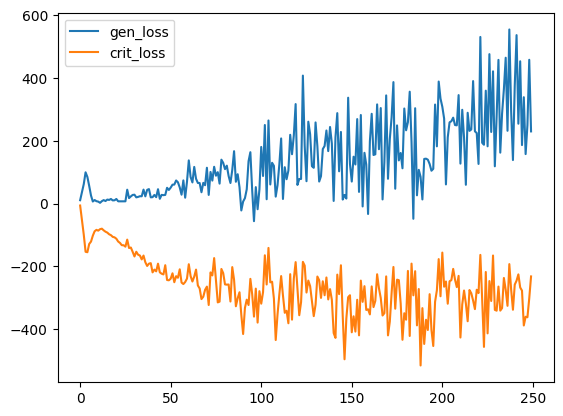



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 11, step : 5500, gen_loss : 319.1146707921028, crit_loss : -281.65900427856434


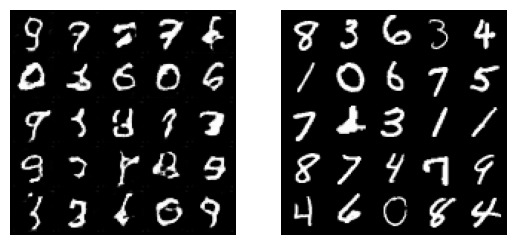

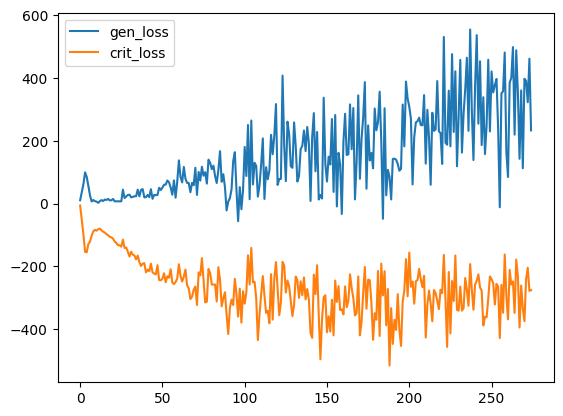



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 12, step : 6000, gen_loss : 318.87742766952516, crit_loss : -307.1224300415039


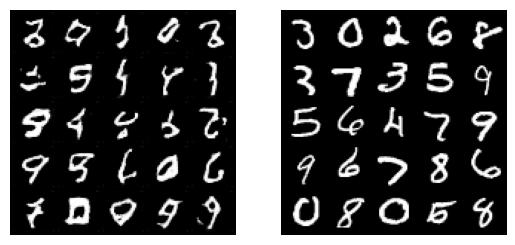

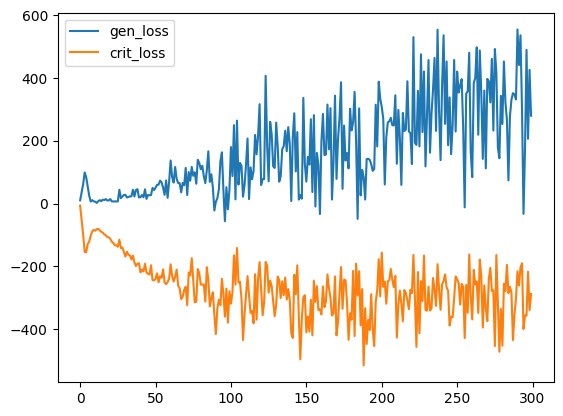



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 13, step : 6500, gen_loss : 364.53259434986114, crit_loss : -317.6952025375367


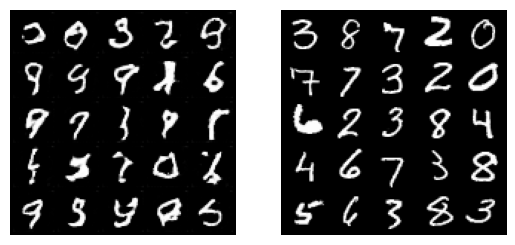

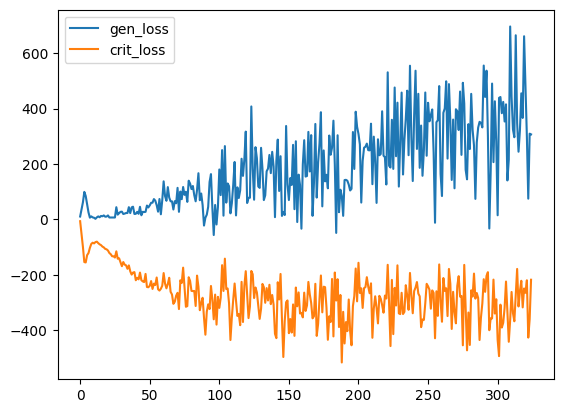



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 14, step : 7000, gen_loss : 370.36086007881164, crit_loss : -278.6618382598877


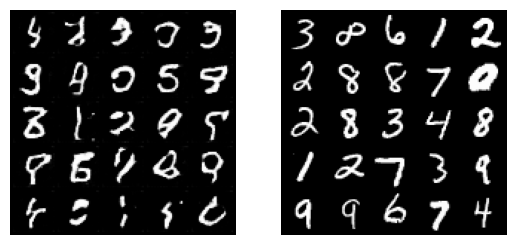

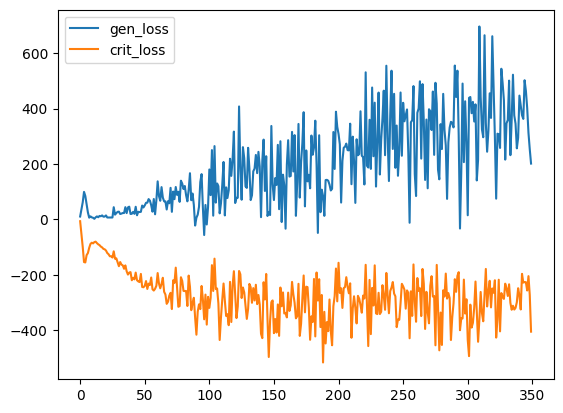



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 15, step : 7500, gen_loss : 376.9589563617706, crit_loss : -304.30848082122816


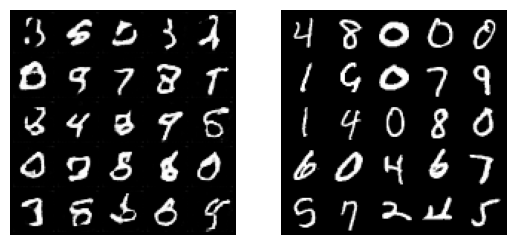

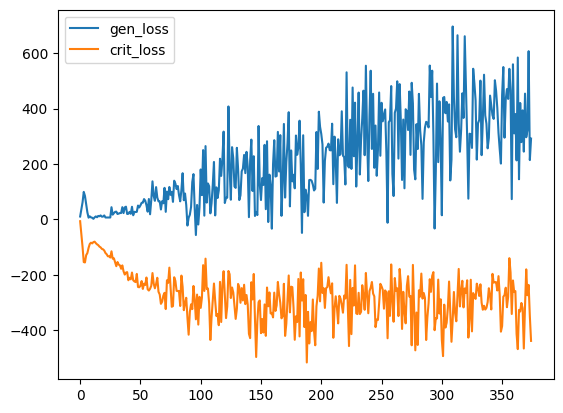



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 17, step : 8000, gen_loss : 339.24342860507966, crit_loss : -329.0205148529051


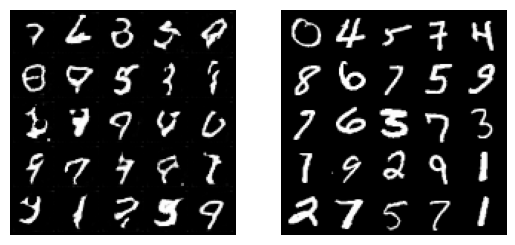

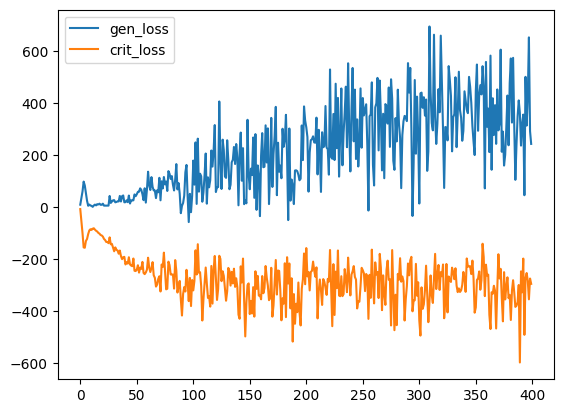



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 18, step : 8500, gen_loss : 391.3318378067017, crit_loss : -310.2184701248169


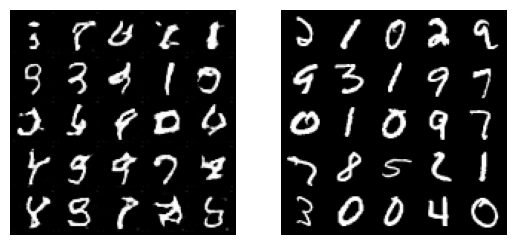

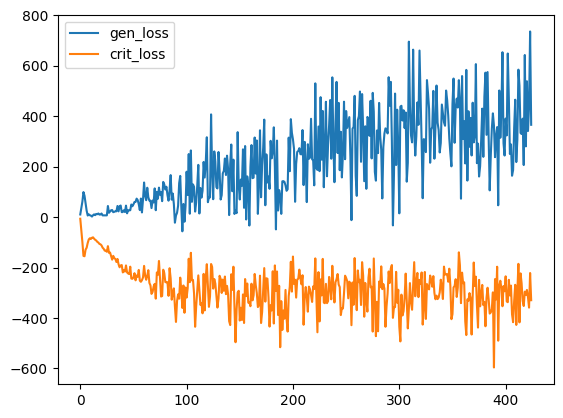



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 19, step : 9000, gen_loss : 380.0115510849953, crit_loss : -326.00113630676293


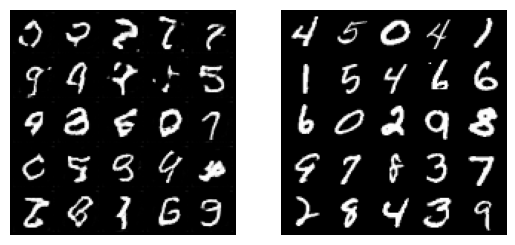

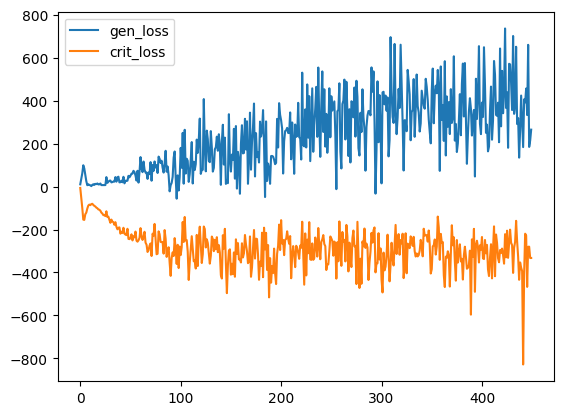



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 20, step : 9500, gen_loss : 382.2071716284752, crit_loss : -313.74155267791735


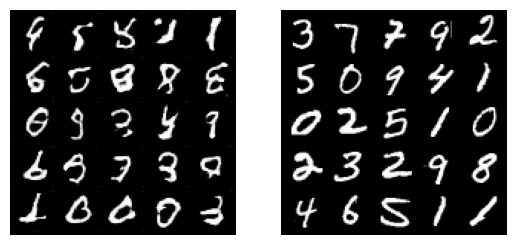

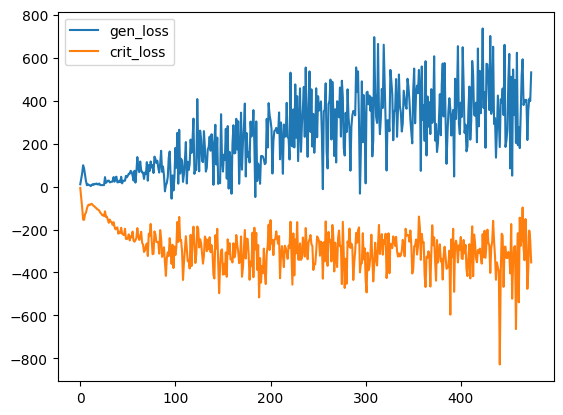



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 21, step : 10000, gen_loss : 409.2239393968582, crit_loss : -294.0546298980709


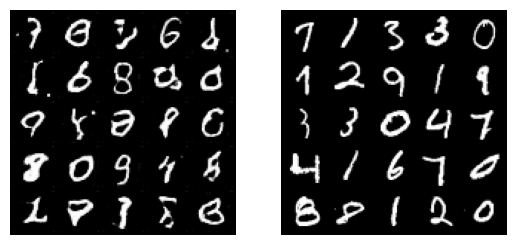

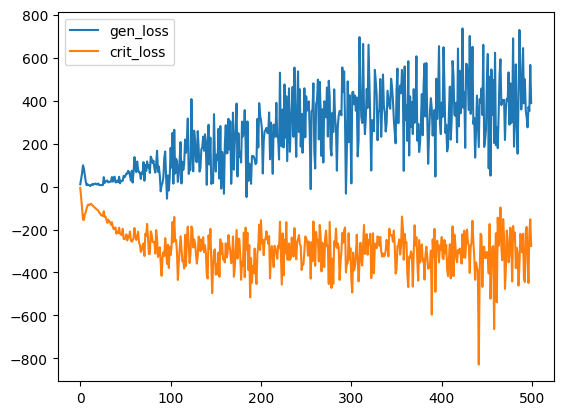



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 22, step : 10500, gen_loss : 386.5638149175644, crit_loss : -278.4028820404054


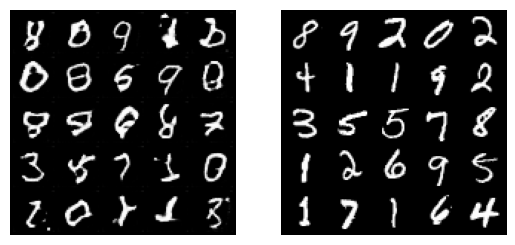

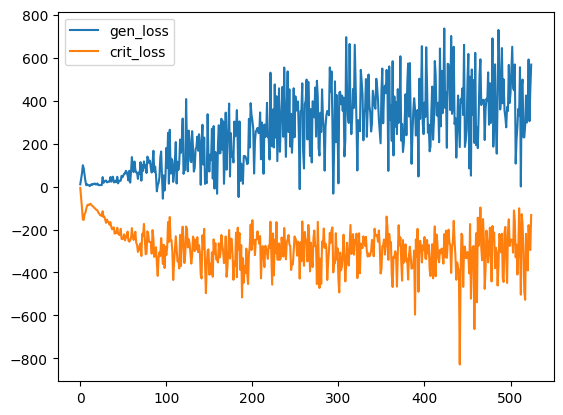



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 23, step : 11000, gen_loss : 416.2126825313568, crit_loss : -287.45796045074474


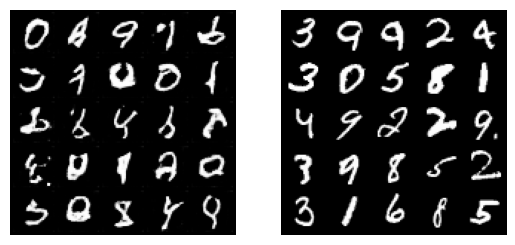

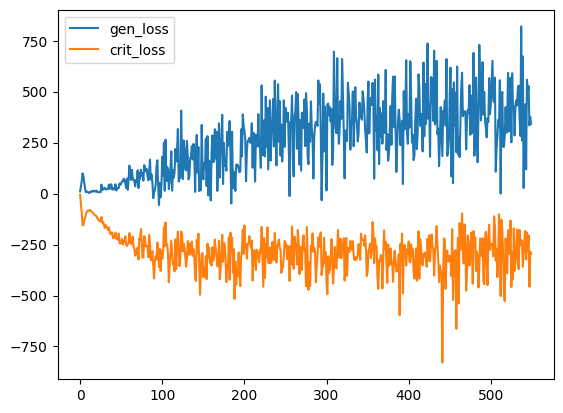



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 24, step : 11500, gen_loss : 421.77843212509157, crit_loss : -303.33267948760994


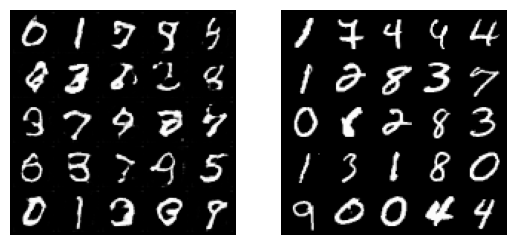

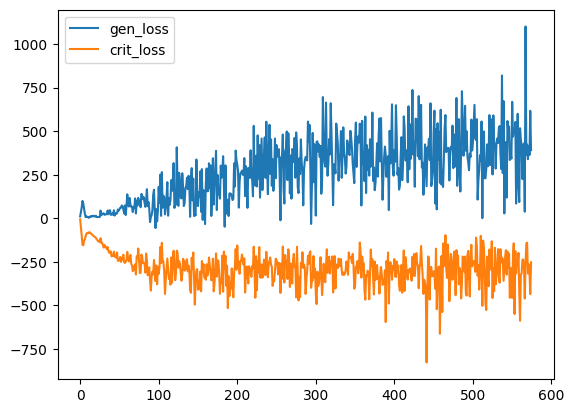



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 25, step : 12000, gen_loss : 349.80755313301086, crit_loss : -298.2088330566407


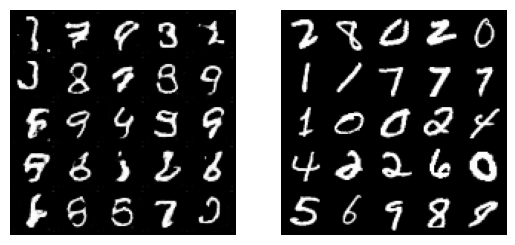

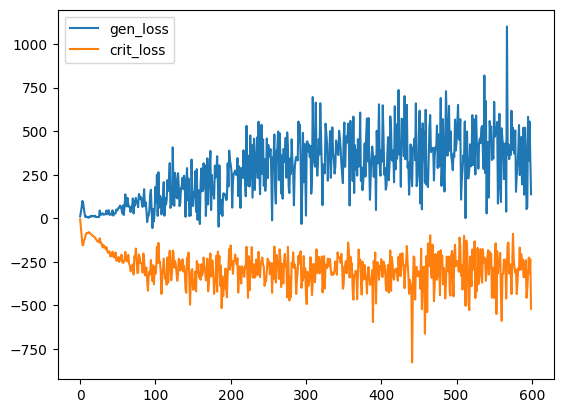



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 26, step : 12500, gen_loss : 361.7972238931656, crit_loss : -318.70380903930663


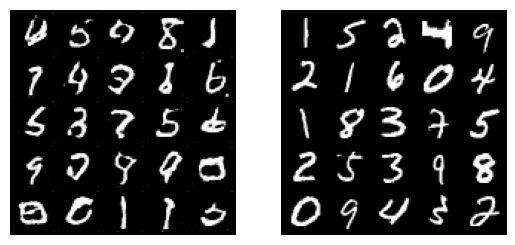

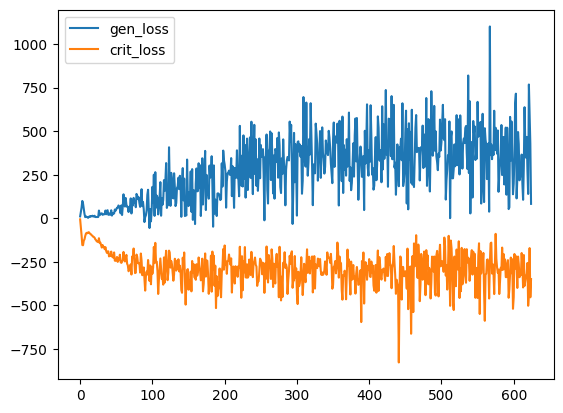



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 27, step : 13000, gen_loss : 397.94215821027757, crit_loss : -313.094429748535


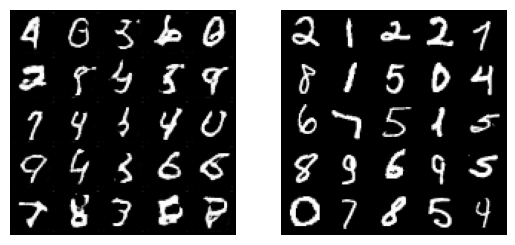

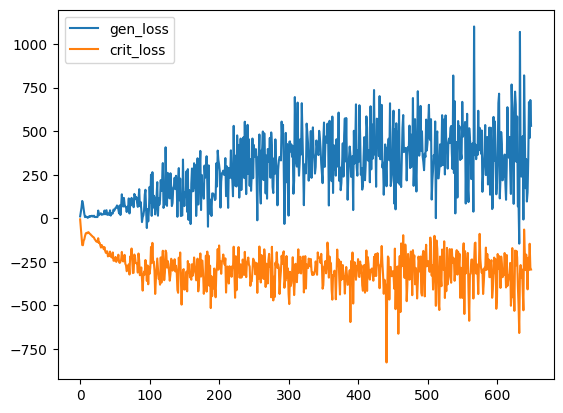



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 28, step : 13500, gen_loss : 424.6984768562317, crit_loss : -339.6590795013426


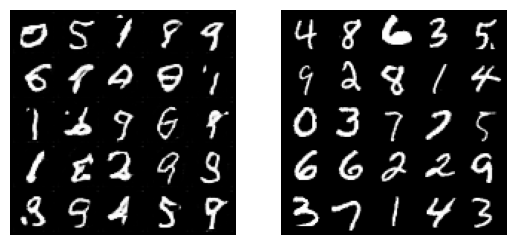

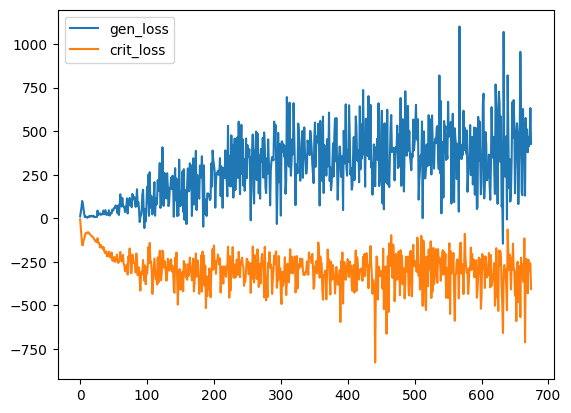



----------------------------------------------------------------------------------------------------




  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 29, step : 14000, gen_loss : 391.3935471258163, crit_loss : -314.74463296966576


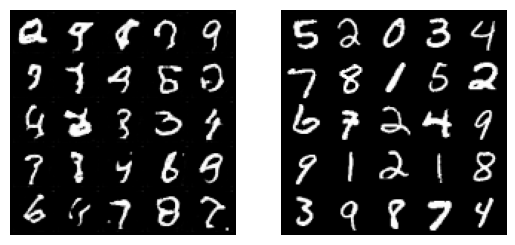

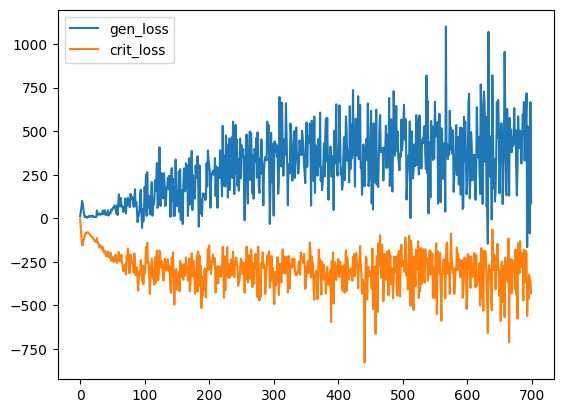



----------------------------------------------------------------------------------------------------




In [35]:
gen_losses = []
crit_losses = []
step_cnt = 0

for epoch in range(num_epochs):
    for real, _ in tqdm(dataloader):
        real = real.to(device)

        crit_loss = 0.0
        for _ in range(crit_repeats):
            noise = get_noise(len(real), noise_dim, device)
            fake = gen(noise).detach()

            eps = torch.rand(len(real), 1, 1, 1, device = device, requires_grad = True)
            grad = get_gradient(crit, real, fake, eps)
            gp = gradient_penalty(grad)

            crit_loss_r = get_crit_loss(crit, real, fake, gp, c_lambda)

            crit_opt.zero_grad()
            crit_loss_r.backward(retain_graph = True)
            crit_opt.step()

            crit_loss += crit_loss_r.item() / crit_repeats

        crit_losses.append(crit_loss)

        ##

        noise = get_noise(len(real), noise_dim, device)
        fake = gen(noise)
        gen_loss = get_gen_loss(crit, fake)

        gen_opt.zero_grad()
        gen_loss.backward(retain_graph = True)
        gen_opt.step()

        gen_losses.append(gen_loss.item())

        ####----
        step_cnt += 1

        if step_cnt % display_step == 0:
            gen_loss_print = sum(gen_losses[-display_step:]) / display_step
            crit_loss_print = sum(crit_losses[-display_step:]) / display_step

            print(f"epoch : {epoch}, step : {step_cnt}, gen_loss : {gen_loss_print}, crit_loss : {crit_loss_print}")

            noise = get_noise(25, noise_dim, device)
            fake = gen(noise)
            plt.subplot(1, 2, 1)
            show_images(fake, show = False)
            plt.subplot(1, 2, 2)
            show_images(real, show = True)

            step_bins = 20
            num_ex = (len(gen_losses) // step_bins) * step_bins

            gen_loss_plot = torch.tensor(gen_losses[:num_ex]).view(-1, step_bins).mean(-1)
            crit_loss_plot = torch.tensor(crit_losses[:num_ex]).view(-1, step_bins).mean(-1)

            plt.plot(gen_loss_plot, label = "gen_loss")
            plt.plot(crit_loss_plot, label = "crit_loss")
            plt.legend()
            plt.show()

            print("\n")
            print("-" * 100)
            print("\n")